In [216]:
import pandas as pd
from re import search
from math import sqrt, radians
from sklearn.neighbors import DistanceMetric
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [217]:
google_data=pd.read_json('/Users/santiagoborgnino/Documents/Github/Smart-Tour/Datasets/google_bcn_poi_data.json')
poi_dataset=pd.read_excel('/Users/santiagoborgnino/Documents/Github/Smart-Tour/Datasets/POI_barcelona.xlsx', sheet_name='POI base')
pits_opendata=pd.read_excel('/Users/santiagoborgnino/Documents/Github/Smart-Tour/Datasets/pits_opendata.xls')

In [219]:
poi_dataset

,latitud,longitud,name,name (upercase),part name,tipo,1994,2000,2011,2014,...,5,6,7,8,9,10,11,12,google maps link,google maps link complete
0,41.377228,2.175597,Santa Mònica,SANTA MÒNICA,Centre de la Creativitat,Exposition Centers,0,0,0,139827,...,6596.879362,7375.691263,8610.659158,8611.457831,7038.227739,5658.159697,3582.042442,3256.969466,https://goo.gl/maps/Q32RvKZN5J1hDYjv6,https://www.google.com/maps/place/Santa+M%C3%B...
1,41.388280,2.181421,Arxiu Fotogràfic de Barcelona,ARXIU FOTOGRÀFIC DE BARCELONA,,Exposition Centers,0,0,0,12294,...,1108.438454,1239.298064,1446.803132,1446.937329,1182.595868,950.710395,601.871486,547.251208,https://goo.gl/maps/cvP1pMftWDFhjBvAA,https://www.google.com/maps/place/Arxiu+Fotogr...
2,41.371296,2.149575,CaixaForum Barcelona,CAIXAFORUM BARCELONA,,Exposition Centers,162821,344097,0,775068,...,74526.277490,83324.672705,97276.354242,97285.377018,79512.279173,63921.371988,40467.056367,36794.641357,https://goo.gl/maps/SQ8BKWVkG6mnZNjY6,https://www.google.com/maps/place/CaixaForum+B...
3,41.391705,2.164946,Casa Batlló,CASA BATLLÓ,,Areas of architectural interest,0,0,0,930000,...,106397.216013,118958.218491,138876.294695,138889.176033,113515.466326,91257.154554,57772.671367,52529.759119,https://goo.gl/maps/YWpu6eP1x9QAFQdy8,https://www.google.com/maps/place/Casa+Batll%C...
4,41.414448,2.153534,GAUDÍ HOUSE MUSEUM,GAUDÍ HOUSE MUSEUM,,Areas of architectural interest,0,0,0,320000,...,33786.038538,37774.737959,44099.648661,44103.739082,36046.412338,28978.368572,18345.496005,16680.628803,https://goo.gl/maps/DmDq3vQ4XQLHNLPx7,https://www.google.com/maps/place/Gaud%C3%AD+H...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,41.388826,2.174019,Teatre Museu El Rei de la Màgia,TEATRE MUSEU EL REI DE LA MÀGIA,,Museums and Collections,0,0,0,0,...,1324.552171,1480.925652,1728.888260,1729.048621,1413.168154,1136.071663,719.219169,653.949502,https://goo.gl/maps/aT9pyqYQdWuUNp2NA,https://www.google.com/maps/place/Teatre+Museu...
119,41.368820,2.163033,TELEFÈRIC DE MONTJUÏC (BARCELONA CABLE CAR),TELEFÈRIC DE MONTJUÏC (BARCELONA CABLE CAR),,Cableway,0,444899,0,1328468,...,149178.213861,166789.839280,194716.726307,194734.787072,159158.624132,127950.521907,81002.344304,73651.322220,https://g.page/TelefericdeMontjuic?share,https://www.google.com/maps/place/Telef%C3%A8r...
120,41.415833,2.111768,Torre de Collserola,TORRE DE COLLSEROLA,,Leisure Spaces,0,0,0,0,...,505.112845,564.745267,659.304847,659.366001,538.906207,433.236532,274.271447,249.381112,https://goo.gl/maps/qqNEscsw2ggdy6E66,https://www.google.com/maps/place/Torre+de+Col...
121,41.347922,1.696869,VINSEUM,VINSEUM,Vilafranca del Penedès),Museums and Collections,0,0,0,0,...,936.949123,1047.563110,1222.964541,1223.077976,999.633454,803.623573,508.754418,462.584582,https://g.page/VINSEUM?share,https://www.google.com/maps/place/VINSEUM/@41....


#### Formatting

In [220]:
#Google Maps Scraping Dataset
google_data.rename(columns={'title':'name'}, inplace=True)
google_data['name']=google_data['name'].str.upper()
google_data.columns = google_data.columns.str.strip()
google_data['name']=google_data['name'].str.strip()
google_data=google_data.drop(['subTitle', 'address', 'locatedIn', 'plusCode', 'url','placeId','website', 'phone','searchString', 'scrapedAt', 'popularTimesLiveText','popularTimesLivePercent' , 'reviewsDistribution', 'reviews','imageUrls'], axis=1)
google_data.drop(['temporarilyClosed', 'permanentlyClosed'], axis=1)
google_data.drop_duplicates(subset=['name'], inplace=True)
google_data.set_index('name', inplace=True)

#Obervatorium de Barcelona Data Set
poi_dataset=poi_dataset.drop(['google maps link', 'google maps link complete' ], axis=1)
poi_dataset.drop('name', axis=1, inplace=True)
poi_dataset=poi_dataset.rename(columns={'name (upercase)':'name', 'tipo1':'category', 'longitud2':'longitud', 'latitud2':'latitud'})
poi_dataset.drop('part name', axis=1, inplace=True)
poi_dataset.drop_duplicates(subset=['name'], inplace=True)
poi_dataset.set_index('name', inplace=True)

In [221]:
google_data=google_data[google_data['permanentlyClosed']==False]

In [222]:
model_data=google_data.join(poi_dataset, how='left')


In [223]:
#Drop POIs that don't have visiting data
model_data=model_data.dropna(subset=[1], axis=0)

In [224]:
model_data.shape

(116, 32)

In [225]:
years=[1994, 2000, 2011, 2014, 2015, 2016, 2017, 2018, 2019]
months=[1,2,3,4,5,6,7,8,9,10,11,12]
model_data=model_data.drop(years, axis=1)


In [226]:
model_data.columns

Index([         'categoryName',     'temporarilyClosed',
           'permanentlyClosed',            'totalScore',
                    'location', 'popularTimesHistogram',
                'reviewsCount',               'latitud',
                    'longitud',                  'tipo',
                     'Average',                       1,
                             2,                       3,
                             4,                       5,
                             6,                       7,
                             8,                       9,
                            10,                      11,
                            12],
      dtype='object')

In [227]:
#Assign park guell data to sagrada familia

In [228]:
model_data=model_data.append(model_data.loc['PARK GÜELL'].copy())

In [229]:
model_data=model_data.reset_index()

In [230]:
model_data.name.value_counts()

PARK GÜELL                                2
VERDAGUER HOUSE-MUSEUM                    1
CASTELL DE GELIDA                         1
MUSEU DEL DISSENY DE BARCELONA            1
MUSEU NACIONAL D'ART DE CATALUNYA         1
                                         ..
ESPAIS VOLART                             1
ESPAI BOMBERS PARC DE LA PREVENCIÓ        1
MUSEU D'AUTÒMATS                          1
EL TER INDUSTRIAL MUSEUM – CAN SANGLAS    1
FUNDACIÓ ANTONI TÀPIES                    1
Name: name, Length: 116, dtype: int64

In [231]:
model_data=model_data.drop(['Average', 'location','temporarilyClosed', 'permanentlyClosed'], axis=1)

In [232]:
model_data.iloc[len(model_data)-1,0]='LA SAGRADA FAMILIA2'

In [233]:
model_data.head()

,name,categoryName,totalScore,popularTimesHistogram,reviewsCount,latitud,longitud,tipo,1,2,3,4,5,6,7,8,9,10,11,12
0,MONTJUÏC CASTLE,Castle,4.4,"{'Su': [{'hour': 6, 'occupancyPercent': 0}, {'...",36979,41.364433,2.167106,Museums and Collections,37473.901759,43391.508523,52225.124478,71440.552584,80648.358602,90169.512164,105267.277054,105277.041020,86043.943424,69172.296055,43791.287896,39817.196440
1,COSMOCAIXA BARCELONA,Museum,4.6,"{'Su': [{'hour': 6, 'occupancyPercent': 0}, {'...",23944,41.413270,2.130658,Museums and Collections,44432.163152,51448.568087,61922.435150,84705.838973,95623.376781,106912.445403,124813.606514,124825.183481,102020.829245,82016.406076,51922.579639,47210.567500
2,MUSEU NACIONAL D'ART DE CATALUNYA,Art museum,4.6,"{'Su': [{'hour': 6, 'occupancyPercent': 0}, {'...",18928,41.368855,2.153363,Museums and Collections,39308.963568,45516.349983,54782.539824,74938.929415,84597.633054,94585.028573,110422.116844,110432.358943,90257.434603,72559.598491,45935.706177,41767.007191
3,CENTRE DE CULTURA CONTEMPORÀNIA DE BARCELONA,Cultural center,4.5,"{'Su': [{'hour': 6, 'occupancyPercent': 0}, {'...",7432,41.383884,2.166795,Exposition Centers,20682.337228,23948.341912,28823.730264,39428.976726,44510.885475,49765.734838,58098.389037,58103.777897,47488.779412,38177.096237,24168.985385,21975.632256
4,PARC DEL LABERINT D'HORTA,City park,4.4,"{'Su': [{'hour': 6, 'occupancyPercent': 0}, {'...",12500,41.437927,2.147543,Leisure Spaces,11073.227368,12821.831118,15432.091416,21110.091154,23830.921514,26644.343475,31105.607863,31108.493034,25425.272108,20439.840150,12939.962610,11765.651524


In [234]:
model_data=model_data.set_index('name')

In [235]:
model_data

,categoryName,totalScore,popularTimesHistogram,reviewsCount,latitud,longitud,tipo,1,2,3,4,5,6,7,8,9,10,11,12
name,,,,,,,,,,,,,,,,,,,
MONTJUÏC CASTLE,Castle,4.4,"{'Su': [{'hour': 6, 'occupancyPercent': 0}, {'...",36979,41.364433,2.167106,Museums and Collections,37473.901759,43391.508523,52225.124478,71440.552584,80648.358602,90169.512164,105267.277054,105277.041020,86043.943424,69172.296055,43791.287896,39817.196440
COSMOCAIXA BARCELONA,Museum,4.6,"{'Su': [{'hour': 6, 'occupancyPercent': 0}, {'...",23944,41.413270,2.130658,Museums and Collections,44432.163152,51448.568087,61922.435150,84705.838973,95623.376781,106912.445403,124813.606514,124825.183481,102020.829245,82016.406076,51922.579639,47210.567500
MUSEU NACIONAL D'ART DE CATALUNYA,Art museum,4.6,"{'Su': [{'hour': 6, 'occupancyPercent': 0}, {'...",18928,41.368855,2.153363,Museums and Collections,39308.963568,45516.349983,54782.539824,74938.929415,84597.633054,94585.028573,110422.116844,110432.358943,90257.434603,72559.598491,45935.706177,41767.007191
CENTRE DE CULTURA CONTEMPORÀNIA DE BARCELONA,Cultural center,4.5,"{'Su': [{'hour': 6, 'occupancyPercent': 0}, {'...",7432,41.383884,2.166795,Exposition Centers,20682.337228,23948.341912,28823.730264,39428.976726,44510.885475,49765.734838,58098.389037,58103.777897,47488.779412,38177.096237,24168.985385,21975.632256
PARC DEL LABERINT D'HORTA,City park,4.4,"{'Su': [{'hour': 6, 'occupancyPercent': 0}, {'...",12500,41.437927,2.147543,Leisure Spaces,11073.227368,12821.831118,15432.091416,21110.091154,23830.921514,26644.343475,31105.607863,31108.493034,25425.272108,20439.840150,12939.962610,11765.651524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PANTÀ DE FOIX,Park,4.4,"{'Su': [{'hour': 4, 'occupancyPercent': 0}, {'...",5016,41.260393,1.644078,Natural spaces,241.535616,279.677169,336.613671,460.465473,519.813793,581.181774,678.493443,678.556377,554.590687,445.845572,282.253921,256.639171
PARC DE LA SERRALADA LITORAL,Park,4.5,"{'Su': [{'hour': 4, 'occupancyPercent': 0}, {'...",159,41.530429,2.340604,Natural spaces,73.337647,84.918596,102.206270,139.811489,157.831466,176.464674,206.011491,206.030600,168.390801,135.372437,85.700977,77.923551
MUSEU DE CIÈNCIES NATURALS DE BARCELONA,Natural history museum,4.4,"{'Su': [{'hour': 6, 'occupancyPercent': 0}, {'...",4687,41.410780,2.220482,Museums and Collections,10946.211774,12674.758143,15255.077417,20867.947588,23557.568628,26338.719198,30748.810596,30751.662672,25133.631203,20205.384706,12791.534606,11630.693470


In [236]:
columns=['popularTimesHistogram']+months
model_data.loc['LA SAGRADA FAMILIA2',['categoryName', 'totalScore', 'reviewsCount', 'latitud', 'longitud', 'tipo']]=model_data.loc['LA SAGRADA FAMILIA',['categoryName', 'totalScore', 'reviewsCount', 'latitud', 'longitud', 'tipo']]
model_data.drop('LA SAGRADA FAMILIA', axis=0, inplace=True)

In [237]:
model_data=model_data.reset_index()

In [238]:
model_data.loc[len(model_data)-1,'name']='LA SAGRADA FAMILIA'

In [239]:
model_data.name.value_counts()

VERDAGUER HOUSE-MUSEUM                              1
PERFUME MUSEUM                                      1
MUSEU DEL DISSENY DE BARCELONA                      1
MUSEU NACIONAL D'ART DE CATALUNYA                   1
MUSEU DE LA CIÈNCIA I DE LA TÈCNICA DE CATALUNYA    1
                                                   ..
ESPAIS VOLART                                       1
ESPAI BOMBERS PARC DE LA PREVENCIÓ                  1
MUSEU D'AUTÒMATS                                    1
EL TER INDUSTRIAL MUSEUM – CAN SANGLAS              1
FUNDACIÓ ANTONI TÀPIES                              1
Name: name, Length: 116, dtype: int64

In [240]:
model_data['totalScore'].value_counts().to_frame().reset_index().sort_values('index', ascending=False)

,index,totalScore
7,4.8,3
8,4.7,3
3,4.6,14
1,4.5,24
0,4.4,24
2,4.3,18
4,4.2,12
5,4.1,7
9,4.0,3
10,3.9,2


<AxesSubplot:>

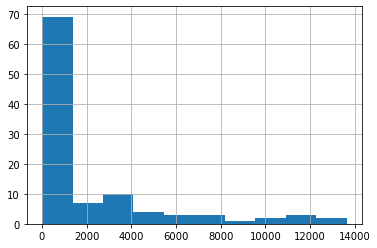

In [241]:
model_data[model_data['reviewsCount']<15000]['reviewsCount'].hist()

In [242]:
model_data=model_data[~model_data['popularTimesHistogram'].isnull()]

In [243]:
model_data.to_csv('model_data.csv')

In [244]:
model_data[model_data.name=="PARK GÜELL"]

,name,categoryName,totalScore,popularTimesHistogram,reviewsCount,latitud,longitud,tipo,1,2,3,4,5,6,7,8,9,10,11,12
98,PARK GÜELL,Park,4.4,"{'Su': [{'hour': 6, 'occupancyPercent': 0}, {'...",124554,41.415419,2.152933,Areas of architectural interest,142556.37459,165067.843291,198672.250786,271770.63762,306798.520553,343018.424809,400452.599691,400489.743291,327324.13905,263141.847654,166588.664328,151470.621005


In [245]:
model_data_content=model_data.copy()

In [246]:
model_data_content.drop(months, axis=1, inplace=True)
model_data_content.drop(['latitud', 'longitud', 'popularTimesHistogram'], axis=1, inplace=True)
model_data_content.reset_index(inplace=True, drop=True)

In [247]:
model_data_content

,name,categoryName,totalScore,reviewsCount,tipo
0,MONTJUÏC CASTLE,Castle,4.4,36979,Museums and Collections
1,COSMOCAIXA BARCELONA,Museum,4.6,23944,Museums and Collections
2,MUSEU NACIONAL D'ART DE CATALUNYA,Art museum,4.6,18928,Museums and Collections
3,CENTRE DE CULTURA CONTEMPORÀNIA DE BARCELONA,Cultural center,4.5,7432,Exposition Centers
4,PARC DEL LABERINT D'HORTA,City park,4.4,12500,Leisure Spaces
...,...,...,...,...,...
71,PANTÀ DE FOIX,Park,4.4,5016,Natural spaces
72,PARC DE LA SERRALADA LITORAL,Park,4.5,159,Natural spaces
73,MUSEU DE CIÈNCIES NATURALS DE BARCELONA,Natural history museum,4.4,4687,Museums and Collections
74,CERCS MINE MUSEUM,Museum,4.5,359,Museums and Collections


In [248]:
score_bins=[0, 4.3, 4.6, 5]
score_labels=['SLOW', 'SMEDIUM', 'SHIGH']
model_data_content['score_cat']=pd.cut(model_data_content['totalScore'], score_bins, include_lowest=True,labels=score_labels)

In [249]:
model_data_content['score_cat'].value_counts()

SMEDIUM    49
SLOW       23
SHIGH       4
Name: score_cat, dtype: int64

In [250]:
review_bins=[0, 1000, 15000, 60000, 200000]
review_labels=['RSLOW', 'RMEDIUM', 'RHIGH', 'RVERY_HIGH']
model_data_content['reviews_cat']=pd.cut(model_data_content['reviewsCount'], review_bins, include_lowest=True,labels=review_labels)

In [251]:
model_data_content['reviews_cat'].value_counts()

RMEDIUM       37
RSLOW         30
RHIGH          6
RVERY_HIGH     3
Name: reviews_cat, dtype: int64

In [252]:
model_data_content.drop(['totalScore', 'reviewsCount'], axis=1, inplace=True)

In [253]:
model_data_content=pd.concat([model_data_content, pd.get_dummies(model_data_content['score_cat'])], axis=1)
model_data_content=pd.concat([model_data_content, pd.get_dummies(model_data_content['reviews_cat'])], axis=1)
model_data_content=pd.concat([model_data_content, pd.get_dummies(model_data_content['tipo'])], axis=1)
model_data_content=pd.concat([model_data_content, pd.get_dummies(model_data_content['categoryName'])], axis=1)

In [254]:
model_data_content.drop(['categoryName', 'tipo', 'score_cat', 'reviews_cat'], axis=1, inplace=True)


In [255]:
model_data_content

,name,SLOW,SMEDIUM,SHIGH,RSLOW,RMEDIUM,RHIGH,RVERY_HIGH,Areas of architectural interest,Cableway,...,Museum,National park,Natural history museum,Nature preserve,Palace,Park,Rail museum,Tourist information center,Transportation service,Zoo
0,MONTJUÏC CASTLE,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,COSMOCAIXA BARCELONA,0,1,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,MUSEU NACIONAL D'ART DE CATALUNYA,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CENTRE DE CULTURA CONTEMPORÀNIA DE BARCELONA,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,PARC DEL LABERINT D'HORTA,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,PANTÀ DE FOIX,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
72,PARC DE LA SERRALADA LITORAL,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
73,MUSEU DE CIÈNCIES NATURALS DE BARCELONA,0,1,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
74,CERCS MINE MUSEUM,0,1,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [256]:
model_data_content.to_csv('model_data_content.csv')

#### Distance Matrix

In [257]:
import haversine as hs
from haversine import Unit

In [258]:
distance_matrix=model_data.copy()
distance_matrix['name'].value_counts()

MARITIME MUSEUM                                      1
ARXIU FOTOGRÀFIC DE BARCELONA                        1
MUSEU OLÍMPIC I DE L'ESPORT JOAN ANTONI SAMARANCH    1
MUSEU EPISCOPAL DE VIC                               1
EL BORN CENTRE DE CULTURA I MEMÒRIA                  1
                                                    ..
CAIXAFORUM BARCELONA                                 1
MUSEU DE LA XOCOLATA                                 1
BALLDOVINA TOWER MUSEUM                              1
COSMOCAIXA BARCELONA                                 1
VIRREINA PALACE                                      1
Name: name, Length: 76, dtype: int64

In [259]:
#Dropping unncessary columns
distance_matrix=distance_matrix.drop(months, axis=1)
distance_matrix=distance_matrix.drop(['categoryName', 'totalScore', 'popularTimesHistogram', 'reviewsCount', 'tipo'], axis=1)

In [260]:
#Creating coordinates columns with long and lat
distance_matrix['coor']=list(zip(distance_matrix.longitud, distance_matrix.latitud))

In [261]:
#Function that calcualtes distance in km between two geolocations
def distance_from(loc1,loc2): 
    dist=hs.haversine(loc1,loc2, unit=Unit.MILES)
    return round(dist,4)

In [262]:
#Create a matrix that calculates distances between each point of interest
for _,row in distance_matrix.iterrows():
    distance_matrix[row['name']]=distance_matrix['coor'].apply(lambda x: distance_from(row.coor,x))

In [263]:
distance_matrix

,name,latitud,longitud,coor,MONTJUÏC CASTLE,COSMOCAIXA BARCELONA,MUSEU NACIONAL D'ART DE CATALUNYA,CENTRE DE CULTURA CONTEMPORÀNIA DE BARCELONA,PARC DEL LABERINT D'HORTA,TELEFÈRIC DE MONTJUÏC (BARCELONA CABLE CAR),...,PARC DE LA SERRALADA DE MARINA,SERRA DE COLLSEROLA NATURAL PARK,PARC DE MONTESQUIU,PARC DEL GARRAF,ESPAI NATURAL DE LES GUILLERIES-SAVASSONA,PANTÀ DE FOIX,PARC DE LA SERRALADA LITORAL,MUSEU DE CIÈNCIES NATURALS DE BARCELONA,CERCS MINE MUSEUM,LA SAGRADA FAMILIA
0,MONTJUÏC CASTLE,41.364433,2.167106,"(2.167106, 41.364433)",0.0000,4.2085,0.9974,1.3431,5.2513,0.4135,...,8.0727,7.6555,51.8777,17.9762,43.2141,36.8451,16.5844,4.8827,60.7546,2.7814
1,COSMOCAIXA BARCELONA,41.413270,2.130658,"(2.1306581, 41.41327)",4.2085,0.0000,3.4446,3.2172,2.0638,3.7977,...,7.6147,4.0793,48.7396,17.0935,41.0834,35.2381,16.6087,6.2086,56.7167,3.1287
2,MUSEU NACIONAL D'ART DE CATALUNYA,41.368855,2.153363,"(2.1533628, 41.368855)",0.9974,3.4446,0.0000,1.3921,4.7860,0.6682,...,8.3690,6.6886,51.6393,17.1773,43.2703,35.9765,17.0823,5.4667,60.1350,2.8456
3,CENTRE DE CULTURA CONTEMPORÀNIA DE BARCELONA,41.383884,2.166795,"(2.1667948, 41.383884)",1.3431,3.2172,1.3921,0.0000,3.9614,1.0721,...,6.9798,7.0365,50.5386,18.4154,41.9656,37.1094,15.7029,4.1483,59.4945,1.4956
4,PARC DEL LABERINT D'HORTA,41.437927,2.147543,"(2.1475434, 41.437927)",5.2513,2.0638,4.7860,3.9614,0.0000,4.8900,...,5.8789,5.3238,46.9233,18.9961,39.0468,36.8833,14.7892,5.3768,55.5352,3.0161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,PANTÀ DE FOIX,41.260393,1.644078,"(1.6440776250015798, 41.2603934067999)",36.8451,35.2381,35.9765,37.1094,36.8833,36.6298,...,42.7600,31.6092,70.8461,19.1101,69.9673,0.0000,51.6114,41.1574,65.5281,37.9970
112,PARC DE LA SERRALADA LITORAL,41.530429,2.340604,"(2.34060377200831, 41.5304291274776)",16.5844,16.6087,17.0823,15.7029,14.7892,16.5837,...,9.0013,20.0058,41.2850,33.6952,29.2078,51.6114,0.0000,11.7098,56.4498,14.3954
113,MUSEU DE CIÈNCIES NATURALS DE BARCELONA,41.410780,2.220482,"(2.220482, 41.41078)",4.8827,6.2086,5.4667,4.1483,5.3768,4.9141,...,3.7071,10.2716,48.5865,22.5527,39.0001,41.1574,11.7098,0.0000,59.2628,3.1798
114,CERCS MINE MUSEUM,42.186040,1.852492,"(1.85249173489762, 42.1860400318951)",60.7546,56.7167,60.1350,59.4945,55.5352,60.3713,...,56.2309,54.9210,25.3414,62.4615,40.2032,65.5281,56.4498,59.2628,0.0000,58.4202


In [264]:
#Dropping remaining unncessary columns
distance_matrix=distance_matrix.drop(['latitud', 'longitud', 'coor'], axis=1)
distance_matrix=distance_matrix.set_index('name')

In [265]:
distance_matrix

,MONTJUÏC CASTLE,COSMOCAIXA BARCELONA,MUSEU NACIONAL D'ART DE CATALUNYA,CENTRE DE CULTURA CONTEMPORÀNIA DE BARCELONA,PARC DEL LABERINT D'HORTA,TELEFÈRIC DE MONTJUÏC (BARCELONA CABLE CAR),RECINTE MODERNISTA DE SANT PAU,EL BORN CENTRE DE CULTURA I MEMÒRIA,MUSEU FREDERIC MARÈS,PICASSO MUSEUM,...,PARC DE LA SERRALADA DE MARINA,SERRA DE COLLSEROLA NATURAL PARK,PARC DE MONTESQUIU,PARC DEL GARRAF,ESPAI NATURAL DE LES GUILLERIES-SAVASSONA,PANTÀ DE FOIX,PARC DE LA SERRALADA LITORAL,MUSEU DE CIÈNCIES NATURALS DE BARCELONA,CERCS MINE MUSEUM,LA SAGRADA FAMILIA
name,,,,,,,,,,,,,,,,,,,,,
MONTJUÏC CASTLE,0.0000,4.2085,0.9974,1.3431,5.2513,0.4135,3.3641,1.8542,1.5211,1.7163,...,8.0727,7.6555,51.8777,17.9762,43.2141,36.8451,16.5844,4.8827,60.7546,2.7814
COSMOCAIXA BARCELONA,4.2085,0.0000,3.4446,3.2172,2.0638,3.7977,3.1156,4.1234,3.7645,3.9735,...,7.6147,4.0793,48.7396,17.0935,41.0834,35.2381,16.6087,6.2086,56.7167,3.1287
MUSEU NACIONAL D'ART DE CATALUNYA,0.9974,3.4446,0.0000,1.3921,4.7860,0.6682,3.3799,2.3873,1.9345,2.2065,...,8.3690,6.6886,51.6393,17.1773,43.2703,35.9765,17.0823,5.4667,60.1350,2.8456
CENTRE DE CULTURA CONTEMPORÀNIA DE BARCELONA,1.3431,3.2172,1.3921,0.0000,3.9614,1.0721,2.0626,1.1653,0.6896,0.9740,...,6.9798,7.0365,50.5386,18.4154,41.9656,37.1094,15.7029,4.1483,59.4945,1.4956
PARC DEL LABERINT D'HORTA,5.2513,2.0638,4.7860,3.9614,0.0000,4.8900,2.6280,4.3848,4.2219,4.3092,...,5.8789,5.3238,46.9233,18.9961,39.0468,36.8833,14.7892,5.3768,55.5352,3.0161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PANTÀ DE FOIX,36.8451,35.2381,35.9765,37.1094,36.8833,36.6298,38.2045,38.2655,37.7859,38.0738,...,42.7600,31.6092,70.8461,19.1101,69.9673,0.0000,51.6114,41.1574,65.5281,37.9970
PARC DE LA SERRALADA LITORAL,16.5844,16.6087,17.0823,15.7029,14.7892,16.5837,14.0061,14.7528,15.1664,14.9151,...,9.0013,20.0058,41.2850,33.6952,29.2078,51.6114,0.0000,11.7098,56.4498,14.3954
MUSEU DE CIÈNCIES NATURALS DE BARCELONA,4.8827,6.2086,5.4667,4.1483,5.3768,4.9141,3.0932,3.0850,3.5330,3.2612,...,3.7071,10.2716,48.5865,22.5527,39.0001,41.1574,11.7098,0.0000,59.2628,3.1798


#### User profile

In [295]:
df_user=model_data_content[(model_data_content['name']=='MONTJUÏC CASTLE') | (model_data_content['name']=='LA SAGRADA FAMILIA')].set_index('name')

In [296]:
userProfile=df_user.transpose().sum(axis=1)
userProfile.to_frame().transpose()
userProfile

SLOW                               0
SMEDIUM                            1
SHIGH                              1
RSLOW                              0
RMEDIUM                            0
RHIGH                              1
RVERY_HIGH                         1
Areas of architectural interest    1
Cableway                           0
Exposition Centers                 0
Leisure Spaces                     0
Museums and Collections            1
Natural spaces                     0
Archaeological museum              0
Art museum                         0
Basilica                           1
Castle                             1
City park                          0
Cultural center                    0
Ethnographic museum                0
Exhibition and trade centre        0
Heritage museum                    0
Hiking area                        0
Historical landmark                0
History museum                     0
Local history museum               0
Maritime museum                    0
M

In [297]:
model_data_content2=model_data_content.set_index('name')

In [298]:
recommendationTable = ((model_data_content2*userProfile).sum(axis=1))/(userProfile.sum())

In [299]:
userProfile.sum()

8

In [300]:
#### Recommendation Output

In [301]:
recommendationTable=recommendationTable.sort_values(ascending=False).head(5).to_frame()
recommendationTable.reset_index(inplace=True)
recommendationTable.columns=['name', 'dotProduct']
recommendationTable

,name,dotProduct
0,LA SAGRADA FAMILIA,0.500
1,MONTJUÏC CASTLE,0.500
2,COSMOCAIXA BARCELONA,0.375
3,MUSEU NACIONAL D'ART DE CATALUNYA,0.375
4,PICASSO MUSEUM,0.375


In [302]:
#pip install dijkstra

In [303]:
recommended_itinerary=[]
for i in recommendationTable['name'].head(5):
    recommended_itinerary.append(i)

In [304]:
recommended_itinerary

['LA SAGRADA FAMILIA',
 'MONTJUÏC CASTLE',
 'COSMOCAIXA BARCELONA',
 "MUSEU NACIONAL D'ART DE CATALUNYA",
 'PICASSO MUSEUM']

In [305]:
graph={recommended_itinerary[0]:{recommended_itinerary[1]:6, recommended_itinerary[2]:2}, 
      recommended_itinerary[1]:{recommended_itinerary[0]:6,recommended_itinerary[2]:2, recommended_itinerary[3]:1, recommended_itinerary[4]:2},
       recommended_itinerary[2]:{recommended_itinerary[0]:2,recommended_itinerary[1]:2, recommended_itinerary[3]:2,recommended_itinerary[4]:3},
      recommended_itinerary[3]:{recommended_itinerary[1]:1, recommended_itinerary[2]:2,recommended_itinerary[4]:3},
       recommended_itinerary[4]:{recommended_itinerary[2]:3,recommended_itinerary[1]:2,recommended_itinerary[3]:3}}
       

In [332]:
def dijkstra(graph,src,dest,visited=[],distances={},predecessors={}):
    """ calculates a shortest path tree routed in src
    """    
    # a few sanity checks
    if src not in graph:
        raise TypeError('The root of the shortest path tree cannot be found')
    if dest not in graph:
        raise TypeError('The target of the shortest path cannot be found')    
    # ending condition
    if src == dest:
        # We build the shortest path and display it
        path=[]
        pred=dest
        while pred != None:
            path.append(pred)
            pred=predecessors.get(pred,None)
        # reverses the array, to display the path nicely
        readable=path[0]
        for index in range(1,len(path)): readable = path[index]+'--->'+readable
        #prints it 
        print('shortest path - array: '+str(path))
        print("path: "+readable+",   cost="+str(distances[dest]))     
    else:     
        # if it is the initial  run, initializes the cost
        if not visited: 
            distances[src]=0
        # visit the neighbors
        for neighbor in graph[src] :
            if neighbor not in visited:
                new_distance = distances[src] + graph[src][neighbor]
                if new_distance < distances.get(neighbor,float('inf')):
                    distances[neighbor] = new_distance
                    predecessors[neighbor] = src
        # mark as visited
        visited.append(src)
        # now that all neighbors have been visited: recurse                         
        # select the non visited node with lowest distance 'x'
        # run Dijskstra with src='x'
        unvisited={}
        for k in graph:
            if k not in visited:
                unvisited[k] = distances.get(k,float('inf'))        
        x=min(unvisited, key=unvisited.get)
        dijkstra(graph,x,dest,visited,distances,predecessors)
        


if __name__ == "__main__":
    #import sys;sys.argv = ['', 'Test.testName']
    #unittest.main()
        
    dijkstra(graph,recommended_itinerary[0], recommended_itinerary[4])

shortest path - array: ['PICASSO MUSEUM', 'COSMOCAIXA BARCELONA', 'LA SAGRADA FAMILIA']
path: LA SAGRADA FAMILIA--->COSMOCAIXA BARCELONA--->PICASSO MUSEUM,   cost=5


In [307]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [308]:
address = 'Barcelona, SP'

geolocator = Nominatim(user_agent="bcn_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Barcelona are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Barcelona are 41.3828939, 2.1774322.


In [312]:
dijkstra=pd.DataFrame()
for name in recommended_itinerary:
    dijkstra=dijkstra.append(model_data[model_data['name']==name])

In [317]:
df=dijkstra[['latitud', 'longitud']]

In [319]:
records = df.to_records(index=False)
points = list(records)
print(result)

[(41.403942, 2.17497), (41.364433, 2.167106), (41.41327, 2.1306581), (41.368855, 2.1533628), (41.38515, 2.1808345)]


In [321]:
points=[(41.403942, 2.17497), (41.364433, 2.167106), (41.41327, 2.1306581), (41.368855, 2.1533628), (41.38515, 2.1808345)]

In [322]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around the Conrad Hotel
for lat, lng, neighborhood in zip(dijkstra.latitud, dijkstra.longitud, dijkstra.name):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        color='blue',
        fill = True,
        popup=label,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)
    
folium.PolyLine(points).add_to(venues_map)

# display map
venues_map
